In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn.functional as F

from sklearn.metrics import f1_score, precision_score, recall_score

## Reading Data

The following cell reads the data and places it in a dictionary formatted to:
```
{
    sub_id: {
        run_id: {
            "eeg": [],
            "aux": [],
            "label": []
        }
    }
}
```

In [2]:
def bandpass_filter(data, lowcut=8, highcut=30, fs=250, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data, axis=1) 

In [3]:
# data loading
eeg_dir = "data/misc/"
label_dir = "data/label/"

data = {}

# reading data
for sub_id in os.listdir(eeg_dir):
    data[sub_id] = {}

    dir_path = os.path.join(eeg_dir, sub_id) 
    for run_id in os.listdir(dir_path):

        # ignoring corrupt data
        if run_id == "run_34":
            continue

        if sub_id == "sub_1":
            if run_id in ["run_1", "run_3"]:
                continue

        if sub_id == "sub_3":
            if run_id in ["run_2", "run_5"]:
                continue


        # getting run number
        i = int(run_id.replace("run_", ""))

        # getting path for aux and eeg
        base_path = os.path.join(dir_path, run_id)
        eeg_path = os.path.join(base_path, f"eeg_run-{i}.npy")
        aux_path = os.path.join(base_path, f"aux_run-{i}.npy")

        # getting path for label
        base_path_label = os.path.join(label_dir, sub_id)
        base_path_label = os.path.join(base_path_label, run_id)

        
        label_path = os.path.join(base_path_label, "labels.npy")

        filtered_eeg = bandpass_filter(np.load(eeg_path))
        
        data[sub_id][run_id] = {
            "eeg": np.load(eeg_path),
            "filtered_eeg": filtered_eeg,
            "aux": np.load(aux_path),
            "label": np.load(label_path)
        }        

## Data Visualization

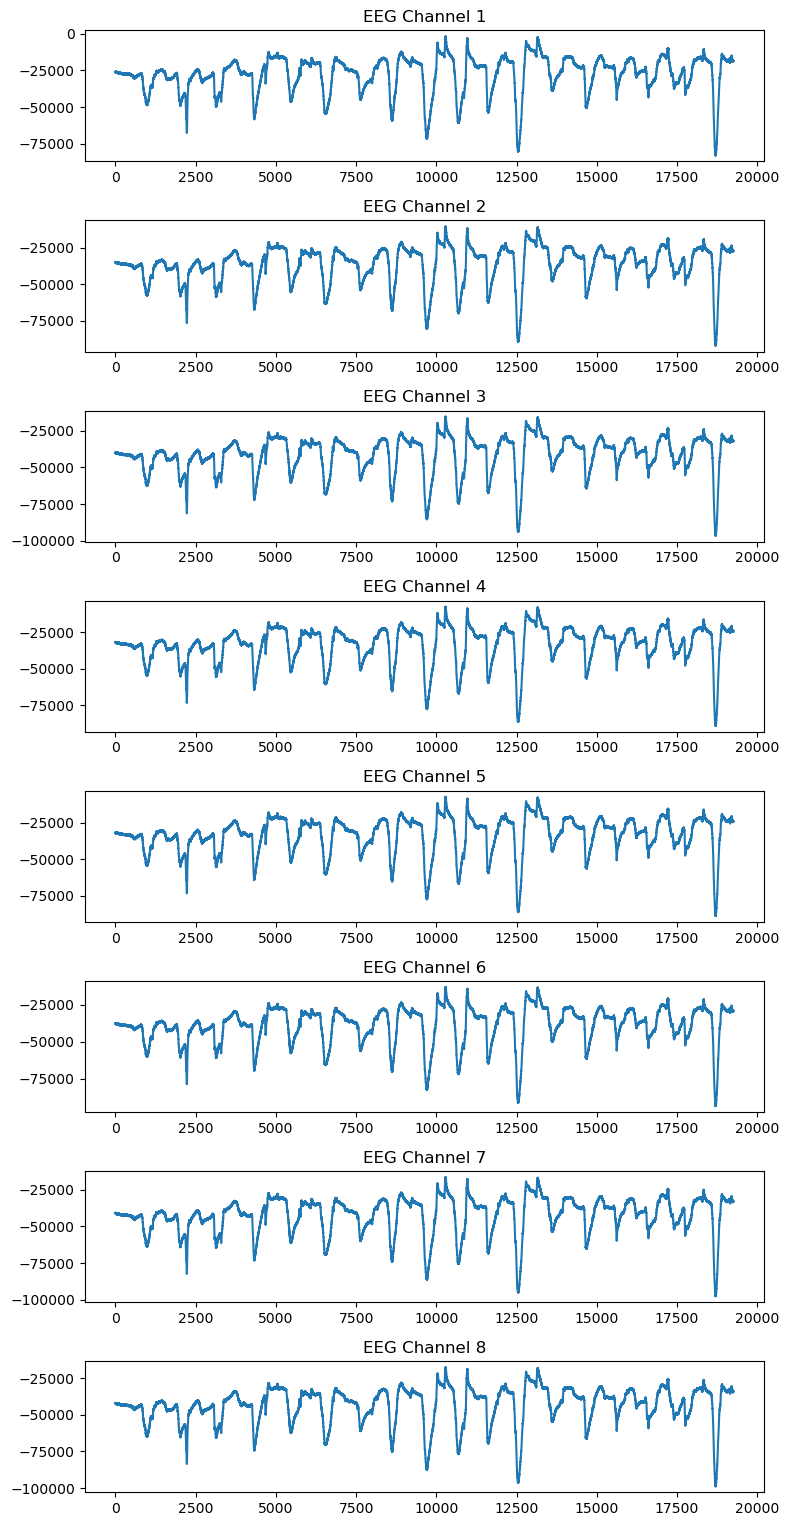

In [4]:
sub_id = "sub_2"
run_id = "run_1"
ignore = 100

eeg_data = data[sub_id][run_id]["eeg"]

# Create subplots
fig, axes = plt.subplots(8, 1, figsize=(8, 16))

for i, ax in enumerate(axes):
    ax.plot(np.arange(len(eeg_data[i][ignore:])), eeg_data[i][ignore:])
    ax.set_title(f"EEG Channel {i+1}")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

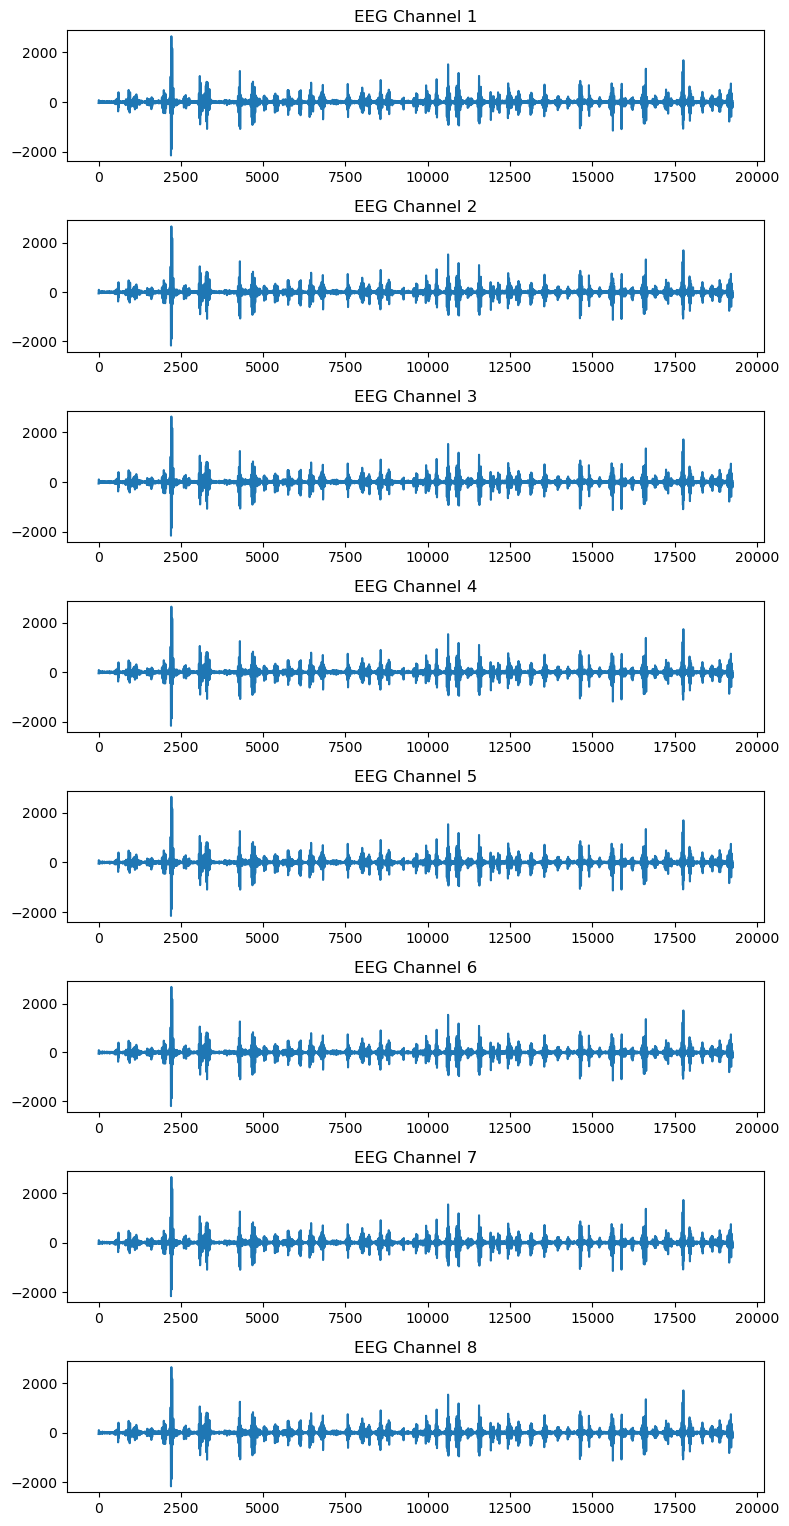

In [5]:
eeg_data = data[sub_id][run_id]["filtered_eeg"]

# Create subplots
fig, axes = plt.subplots(8, 1, figsize=(8, 16))

for i, ax in enumerate(axes):
    ax.plot(np.arange(len(eeg_data[i][ignore:])), eeg_data[i][ignore:])
    ax.set_title(f"EEG Channel {i+1}")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

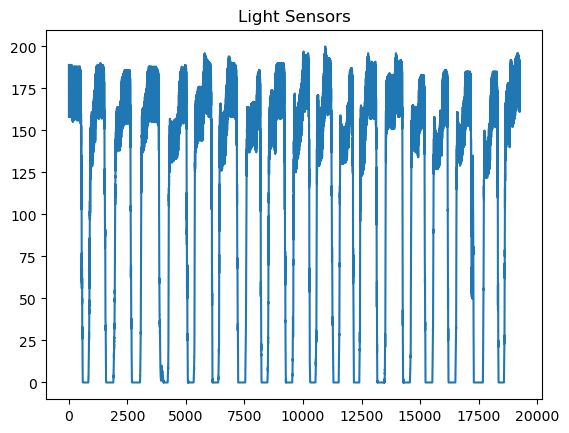

In [6]:
ignore = 100

aux_data = data[sub_id][run_id]["aux"][1]


plt.plot(np.arange(len(aux_data[ignore:])), aux_data[ignore:])
plt.title(f"Light Sensors")
plt.show()

## Cleaning the data

In [7]:
ignore = 100
cleaned_data = {}

for sub_id in list(data.keys()):
    eeg_window = []
    labels = []
    
    for run_id in list(data[sub_id].keys()):
        aux_data = data[sub_id][run_id]["aux"][1][ignore:]
        eeg_data = data[sub_id][run_id]["filtered_eeg"][:, ignore:]
        label_data = data[sub_id][run_id]["label"]
    
        labels.append(label_data)
    
        window_mask = aux_data < 10
        prev = False
        window = []
        
        for i, mask in enumerate(window_mask):
            if mask:
                window.append(eeg_data[:, i])
        
            if prev and not mask and len(window) > 100:
                eeg_window.append(np.asarray(window))
                window = []
                
            prev = mask

    labels = np.asarray(labels).flatten()

    # asserting if data is valid
    assert len(eeg_window) == len(labels)

    split = int(0.8*len(eeg_window))

    cleaned_data[sub_id] = {}

    cleaned_data[sub_id]["train"] = {
        "eeg": eeg_window[:split],
        "label": labels[:split]
    }

    cleaned_data[sub_id]["test"] = {
            "eeg": eeg_window[split:],
            "label": labels[split:]
        }

## Dataloader

In [8]:
class Dataset(Dataset):
    def __init__(self, data: dict, mode: str, sample_window=150):
        """
        Args:
            data: (dict) cleaned data with {eeg: [c, t], label: [t]} where
                        c is channels, and t is time
            mode: (str) one of ["hand", "rps", "both"]
        """
        if mode not in ["hand", "rps", "both"]:
            raise Exception("Not a valid mode, choose one of ['hand', 'rps', 'both']")

        self.mode = mode
        self.eeg_data = data["eeg"]
        self.sample_window = sample_window
        
        if self.mode == "hand":
            self.num_classes = 2
            self.labels = []

            for l in data["label"]:
                if "right" in l:
                    self.labels.append(0)

                elif "left" in l:
                    self.labels.append(1)

                else:
                    raise Exception("incorrect label")

        elif self.mode == "rps":
            self.num_classes = 3
            self.labels = []

            for l in data["label"]:
                if "rock" in l:
                    self.labels.append(0)

                elif "paper" in l:
                    self.labels.append(1)

                elif "scissor" in l:
                    self.labels.append(2)

                else:
                    raise Exception("incorrect label")

        else:
            self.num_classes = 6
            self.labels = []
            
            mapping = {
                "left_rock": 0, 
                "left_paper": 1, 
                "left_scissors": 2, 
                "right_rock": 3, 
                "right_paper": 4, 
                "right_scissors": 5
            }
            
            for l in data["label"]:
                if l not in list(mapping.keys()):
                    raise Exception("incorrect label")

                self.labels.append(mapping[l])


    def __len__(self):
        return len(eeg_data)

    def __getitem__(self, idx):
        eeg = self.eeg_data[idx].transpose()[:, :self.sample_window]
        label = self.labels[idx]

        
        target = np.zeros([self.num_classes])
        target[label] = 1
        return torch.tensor(eeg).to(torch.float32), torch.tensor(target).to(torch.float32)

## Modelling Task 1: Left vs Right

In [9]:
class EEGNet(nn.Module):
    def __init__(self, num_classes=2, channels=8):
        super(EEGNet, self).__init__()

        # Depthwise Convolution
        self.conv1 = nn.Conv2d(1, 16, (1, 64), padding=(0, 32), bias=False)
        self.batchnorm1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, (channels, 1), groups=16, bias=False)
        self.batchnorm2 = nn.BatchNorm2d(32)
        self.pool1 = nn.AvgPool2d((1, 4))
        self.dropout1 = nn.Dropout(0.25)

        # Separable Convolution
        self.conv3 = nn.Conv2d(32, 32, (1, 16), padding=(0, 8), bias=False)
        self.batchnorm3 = nn.BatchNorm2d(32)
        self.pool2 = nn.AvgPool2d((1, 8))
        self.dropout2 = nn.Dropout(0.25)

        # Fully Connected Layer
        self.flatten = nn.Flatten()
        self.fc1 = nn.LazyLinear(num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add a channel dimension [B, 1, C, T]
        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = F.relu(x)

        x = self.conv2(x)
        x = self.batchnorm2(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = self.dropout1(x)


        x = self.conv3(x)
        x = self.batchnorm3(x)
        x = F.relu(x)
        x = self.pool2(x)
        x = self.dropout2(x)


        x = self.flatten(x)
        x = self.fc1(x)


        return F.log_softmax(x, dim=1)

In [10]:
batch_size = 1
epochs = 100
num_classes = 2

mode = "hand"
results = {}

for sub_id in ["sub_1", "sub_2", "sub_3", "sub_4"]:
    print(f"============== {sub_id} ==============\n")
    sample_window = min(min([val.shape[0] for val in cleaned_data[sub_id]["train"]["eeg"]]), min([val.shape[0] for val in cleaned_data[sub_id]["test"]["eeg"]]))
    
    print(f"sample_window = {sample_window}")
    train_set = Dataset(cleaned_data[sub_id]["train"], mode=mode, sample_window=sample_window)
    test_set = Dataset(cleaned_data[sub_id]["test"], mode=mode, sample_window=sample_window)
    
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    model = EEGNet(num_classes=num_classes)
    model.to(device)
    
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct = 0
        for steps, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
    
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()

        if (epoch+1) % 10 == 0: 
            print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}")

    # evaluating
    model.eval()
    y_pred = []
    y_true = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            gt = target.argmax(dim=1, keepdim=True)
            y_pred.append(pred.squeeze().cpu().detach().numpy())
            y_true.append(gt.squeeze().cpu().detach().numpy())
    
    precision = precision_score(y_true, y_pred, average='binary')  # Use 'macro' for multi-class
    recall = recall_score(y_true, y_pred, average='binary')
    f1 = f1_score(y_true, y_pred, average='binary')

    results[sub_id] = {
        "f1": f1,
        "precision": precision,
        "recall": recall,
    }

============== sub_1 ==============

sample_window = 154


/opt/conda/lib/python3.11/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch 10/100, Loss: 0.0894
Epoch 20/100, Loss: 0.0201
Epoch 30/100, Loss: 0.0094
Epoch 40/100, Loss: 0.0037
Epoch 50/100, Loss: 0.0019
Epoch 60/100, Loss: 0.0025
Epoch 70/100, Loss: 0.0017
Epoch 80/100, Loss: 0.0016
Epoch 90/100, Loss: 0.0013
Epoch 100/100, Loss: 0.0017
============== sub_2 ==============

sample_window = 114


/opt/conda/lib/python3.11/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch 10/100, Loss: 0.0986
Epoch 20/100, Loss: 0.0221
Epoch 30/100, Loss: 0.0134
Epoch 40/100, Loss: 0.0060
Epoch 50/100, Loss: 0.0088
Epoch 60/100, Loss: 0.0027
Epoch 70/100, Loss: 0.0017
Epoch 80/100, Loss: 0.0011
Epoch 90/100, Loss: 0.0022
Epoch 100/100, Loss: 0.0008
============== sub_3 ==============

sample_window = 138


/opt/conda/lib/python3.11/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch 10/100, Loss: 0.1323
Epoch 20/100, Loss: 0.0378
Epoch 30/100, Loss: 0.0107
Epoch 40/100, Loss: 0.0080
Epoch 50/100, Loss: 0.0034
Epoch 60/100, Loss: 0.0053
Epoch 70/100, Loss: 0.0029
Epoch 80/100, Loss: 0.0019
Epoch 90/100, Loss: 0.0006
Epoch 100/100, Loss: 0.0008
============== sub_4 ==============

sample_window = 164


/opt/conda/lib/python3.11/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch 10/100, Loss: 0.0737
Epoch 20/100, Loss: 0.0148
Epoch 30/100, Loss: 0.0057
Epoch 40/100, Loss: 0.0060
Epoch 50/100, Loss: 0.0017
Epoch 60/100, Loss: 0.0017
Epoch 70/100, Loss: 0.0024
Epoch 80/100, Loss: 0.0019
Epoch 90/100, Loss: 0.0005
Epoch 100/100, Loss: 0.0010


In [11]:
for sub_id in ["sub_1", "sub_2", "sub_3", "sub_4"]:
    f1 = results[sub_id]["f1"]
    precision = results[sub_id]["precision"]
    recall = results[sub_id]["recall"]
    print(f"{sub_id} ==> Precision: {precision}, Recall: {recall}, F1-score: {f1}")

sub_1 ==> Precision: 0.5, Recall: 1.0, F1-score: 0.6666666666666666
sub_2 ==> Precision: 0.8, Recall: 1.0, F1-score: 0.8888888888888888
sub_3 ==> Precision: 0.3333333333333333, Recall: 0.25, F1-score: 0.2857142857142857
sub_4 ==> Precision: 0.0, Recall: 0.0, F1-score: 0.0


## Modelling Task 2: Rock vs Paper vs Scisors

In [12]:
batch_size = 1
epochs = 100
num_classes = 3

mode = "rps"
results = {}

for sub_id in ["sub_1", "sub_2", "sub_3", "sub_4"]:
    print(f"============== {sub_id} ==============\n")
    sample_window = min(min([val.shape[0] for val in cleaned_data[sub_id]["train"]["eeg"]]), min([val.shape[0] for val in cleaned_data[sub_id]["test"]["eeg"]]))
    
    print(f"sample_window = {sample_window}")
    train_set = Dataset(cleaned_data[sub_id]["train"], mode=mode, sample_window=sample_window)
    test_set = Dataset(cleaned_data[sub_id]["test"], mode=mode, sample_window=sample_window)
    
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    model = EEGNet(num_classes=num_classes)
    model.to(device)
    
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct = 0
        for steps, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
    
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()

        if (epoch+1) % 10 == 0: 
            print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}")

    # evaluating
    model.eval()
    y_pred = []
    y_true = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            gt = target.argmax(dim=1, keepdim=True)
            y_pred.append(pred.squeeze().cpu().detach().numpy())
            y_true.append(gt.squeeze().cpu().detach().numpy())
    
    precision = precision_score(y_true, y_pred, average='macro')  # Use 'macro' for multi-class
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='weighted')

    results[sub_id] = {
        "f1": f1,
        "precision": precision,
        "recall": recall,
    }

============== sub_1 ==============

sample_window = 154


/opt/conda/lib/python3.11/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch 10/100, Loss: 0.2361
Epoch 20/100, Loss: 0.0675
Epoch 30/100, Loss: 0.0305
Epoch 40/100, Loss: 0.0120
Epoch 50/100, Loss: 0.0231
Epoch 60/100, Loss: 0.0038
Epoch 70/100, Loss: 0.0071
Epoch 80/100, Loss: 0.0027
Epoch 90/100, Loss: 0.0024
Epoch 100/100, Loss: 0.0066
============== sub_2 ==============

sample_window = 114


/opt/conda/lib/python3.11/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch 10/100, Loss: 0.3363
Epoch 20/100, Loss: 0.1185
Epoch 30/100, Loss: 0.0481
Epoch 40/100, Loss: 0.0346
Epoch 50/100, Loss: 0.0197
Epoch 60/100, Loss: 0.0094
Epoch 70/100, Loss: 0.0105
Epoch 80/100, Loss: 0.0040
Epoch 90/100, Loss: 0.0043
Epoch 100/100, Loss: 0.0037
============== sub_3 ==============

sample_window = 138


/opt/conda/lib/python3.11/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch 10/100, Loss: 0.4635
Epoch 20/100, Loss: 0.0808
Epoch 30/100, Loss: 0.0328
Epoch 40/100, Loss: 0.0177
Epoch 50/100, Loss: 0.0186
Epoch 60/100, Loss: 0.0067
Epoch 70/100, Loss: 0.0078
Epoch 80/100, Loss: 0.0056
Epoch 90/100, Loss: 0.0040
Epoch 100/100, Loss: 0.0025
============== sub_4 ==============

sample_window = 164


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch 10/100, Loss: 0.2542
Epoch 20/100, Loss: 0.0531
Epoch 30/100, Loss: 0.0239
Epoch 40/100, Loss: 0.0108
Epoch 50/100, Loss: 0.0077
Epoch 60/100, Loss: 0.0109
Epoch 70/100, Loss: 0.0050
Epoch 80/100, Loss: 0.0055
Epoch 90/100, Loss: 0.0034
Epoch 100/100, Loss: 0.0022


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [13]:
for sub_id in ["sub_1", "sub_2", "sub_3", "sub_4"]:
    f1 = results[sub_id]["f1"]
    precision = results[sub_id]["precision"]
    recall = results[sub_id]["recall"]
    print(f"{sub_id} ==> Precision: {precision}, Recall: {recall}, F1-score: {f1}")

sub_1 ==> Precision: 0.27777777777777773, Recall: 0.38888888888888884, F1-score: 0.3142857142857143
sub_2 ==> Precision: 0.3, Recall: 0.3055555555555555, F1-score: 0.35416666666666663
sub_3 ==> Precision: 0.0, Recall: 0.0, F1-score: 0.0
sub_4 ==> Precision: 0.09523809523809523, Recall: 0.2222222222222222, F1-score: 0.15000000000000002


## Modelling Task 3: Rock vs Paper vs Scisors

In [14]:
batch_size = 1
epochs = 100
num_classes = 6

mode = "both"
results = {}

for sub_id in ["sub_1", "sub_2", "sub_3", "sub_4"]:
    print(f"============== {sub_id} ==============\n")
    sample_window = min(min([val.shape[0] for val in cleaned_data[sub_id]["train"]["eeg"]]), min([val.shape[0] for val in cleaned_data[sub_id]["test"]["eeg"]]))
    
    print(f"sample_window = {sample_window}")
    train_set = Dataset(cleaned_data[sub_id]["train"], mode=mode, sample_window=sample_window)
    test_set = Dataset(cleaned_data[sub_id]["test"], mode=mode, sample_window=sample_window)
    
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    model = EEGNet(num_classes=num_classes)
    model.to(device)
    
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct = 0
        for steps, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
    
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()

        if (epoch+1) % 10 == 0: 
            print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}")

    # evaluating
    model.eval()
    y_pred = []
    y_true = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            gt = target.argmax(dim=1, keepdim=True)
            y_pred.append(pred.squeeze().cpu().detach().numpy())
            y_true.append(gt.squeeze().cpu().detach().numpy())
    
    precision = precision_score(y_true, y_pred, average='macro')  # Use 'macro' for multi-class
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='weighted')

    results[sub_id] = {
        "f1": f1,
        "precision": precision,
        "recall": recall,
    }

============== sub_1 ==============

sample_window = 154


/opt/conda/lib/python3.11/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch 10/100, Loss: 0.5480
Epoch 20/100, Loss: 0.2017
Epoch 30/100, Loss: 0.0406
Epoch 40/100, Loss: 0.0337
Epoch 50/100, Loss: 0.0267
Epoch 60/100, Loss: 0.0178
Epoch 70/100, Loss: 0.0169
Epoch 80/100, Loss: 0.0103
Epoch 90/100, Loss: 0.0027
Epoch 100/100, Loss: 0.0057
============== sub_2 ==============

sample_window = 114


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch 10/100, Loss: 0.7108
Epoch 20/100, Loss: 0.1956
Epoch 30/100, Loss: 0.0883
Epoch 40/100, Loss: 0.0728
Epoch 50/100, Loss: 0.0407
Epoch 60/100, Loss: 0.0234
Epoch 70/100, Loss: 0.0224
Epoch 80/100, Loss: 0.0086
Epoch 90/100, Loss: 0.0216
Epoch 100/100, Loss: 0.0105
============== sub_3 ==============

sample_window = 138


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch 10/100, Loss: 0.9832
Epoch 20/100, Loss: 0.3581
Epoch 30/100, Loss: 0.1908
Epoch 40/100, Loss: 0.1549
Epoch 50/100, Loss: 0.0556
Epoch 60/100, Loss: 0.0413
Epoch 70/100, Loss: 0.0204
Epoch 80/100, Loss: 0.0149
Epoch 90/100, Loss: 0.0109
Epoch 100/100, Loss: 0.0103
============== sub_4 ==============

sample_window = 164


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch 10/100, Loss: 0.5757
Epoch 20/100, Loss: 0.1392
Epoch 30/100, Loss: 0.0511
Epoch 40/100, Loss: 0.0251
Epoch 50/100, Loss: 0.0233
Epoch 60/100, Loss: 0.0119
Epoch 70/100, Loss: 0.0080
Epoch 80/100, Loss: 0.0106
Epoch 90/100, Loss: 0.0082
Epoch 100/100, Loss: 0.0039


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [15]:
for sub_id in ["sub_1", "sub_2", "sub_3", "sub_4"]:
    f1 = results[sub_id]["f1"]
    precision = results[sub_id]["precision"]
    recall = results[sub_id]["recall"]
    print(f"{sub_id} ==> Precision: {precision}, Recall: {recall}, F1-score: {f1}")

sub_1 ==> Precision: 0.16666666666666666, Recall: 0.25, F1-score: 0.29166666666666663
sub_2 ==> Precision: 0.027777777777777776, Recall: 0.08333333333333333, F1-score: 0.0625
sub_3 ==> Precision: 0.25, Recall: 0.27777777777777773, F1-score: 0.3392857142857143
sub_4 ==> Precision: 0.19999999999999998, Recall: 0.16666666666666666, F1-score: 0.23809523809523808
